In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import os
import shutil
from pathlib import Path

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import osmnx as ox
import pandas as pd
import shapely as shp
from lib import getPopulation as gp
from lib import setActionsAndTransitions_2 as actrans

/opt/anaconda3/envs/tsuevac/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.0-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [3]:
def createFolders():
    tempfolder = Path("./tmp")
    if not Path.exists(tempfolder):
        Path.mkdir(tempfolder)
    datafolder = Path("./data")
    if not Path.exists(datafolder):
        Path.mkdir(datafolder)


def get_area_from_geojson(aos_file):
    gdf = gpd.read_file(aos_file)
    bbox = gdf.total_bounds
    area = {"north": bbox[3], "south": bbox[1], "east": bbox[2], "west": bbox[0]}
    return area


def createBoundingBox(
    area={"north": 33.58, "south": 33.53, "east": 133.58, "west": 133.52}
):
    # create a Bounding Box
    # returns a shapely geometry
    bbox = shp.geometry.box(area["west"], area["south"], area["east"], area["north"])
    return bbox


def createGraph(
    area={"north": 33.58, "south": 33.53, "east": 133.58, "west": 133.52},
    crs="EPSG:6690",
    ntype="drive",
    simplify=False,
):
    # NEW AREA (Aug, 2021)
    maprange = area  # Degree 1.0 = 111km. 2.22km x 4.44km square.
    # Obtain the roadmap data from OpenStreetMap by using OSMNX
    G = ox.graph_from_bbox(
        maprange["north"],
        maprange["south"],
        maprange["east"],
        maprange["west"],
        network_type=ntype,
        simplify=simplify,
    )
    G_projected = ox.project_graph(G, to_crs=crs)
    if simplify:
        # Simplify topology
        G_out = ox.simplification.consolidate_intersections(
            G_projected,
            tolerance=10,
            rebuild_graph=True,
            dead_ends=False,
            reconnect_edges=True,
        )
        print(
            f"""
        The graph was saved as 'graph.gpkg' with projection {crs}.
        This is a SIMPLIFIED {ntype} type OSM network.
        """
        )
    else:
        G_out = G_projected
        print(
            f"""
        The graph was saved as 'graph.gpkg' with projection {crs}.
        This is an {ntype} type OSM network.
        """
        )
    # save the OSM data as Geopackage
    ox.io.save_graph_geopackage(G_out, filepath="./tmp/graph.gpkg")
    # # Draw a map
    # if plot:
    #     ox.plot_graph(G_out, bgcolor="white", node_color="red", edge_color="black")
    # # Create edges file
    # edges = gpd.read_file("./tmp/graph.gpkg", layer="edges")
    # edges.to_file("./tmp/edges.shp")
    nnodes = G.number_of_nodes()
    nedges = G.number_of_edges()
    print(f"{nnodes} nodes and {nedges} edges in graph.")
    return G_out

def createLinksAndNodes(G,shelters, plot=True):
    # Get nodes and edge from graph
    n, e = ox.graph_to_gdfs(G)
    # Create nodes db
    nodesdb = n[['x','y']].copy()
    nodesdb.reset_index(inplace=True)
    nodesdb['evacuation'] = pd.Series([ 0 for _ in range(nodesdb.shape[0])])
    nodesdb['reward'] = pd.Series([ 1 for _ in range(nodesdb.shape[0])])
    nodesdb['number'] = pd.Series([ i for i in range(nodesdb.shape[0])])
    nodesdb = nodesdb.rename(columns={'x' : 'coord_x', 'y': 'coord_y'})
    nodesdb0 = nodesdb[['number','osmid','coord_x','coord_y','evacuation','reward']]
    nodesdb0.to_csv('./tmp/nodesdb0.csv',index=False)
    # Create linksdb
    linksdb = np.zeros((e.shape[0],5),dtype=np.int64)
    for i,j in enumerate(e.iterrows()):
        u = j[0][0]
        v = j[0][1]
        linksdb[i,:] = [i,u,v,-1,3]
    linksdb0 = pd.DataFrame(linksdb, columns=['number','node1','node2','length','width'])
    # Recalculate lengths
    length = []
    for i in range(linksdb0.shape[0]):
        p1 = [nodesdb0[nodesdb['osmid']==linksdb0['node1'][i]]['coord_x'].values.item(),
            nodesdb0[nodesdb['osmid']==linksdb0['node2'][i]]['coord_x'].values.item()]
        p2 = [nodesdb0[nodesdb['osmid']==linksdb0['node1'][i]]['coord_y'].values.item(),
            nodesdb0[nodesdb['osmid']==linksdb0['node2'][i]]['coord_y'].values.item()]
        length.append(np.ceil(np.sqrt((p1[1]-p1[0])**2 + (p2[1]-p2[0])**2)))
    linksdb0['length'] = length
    linksdb0.to_csv('./tmp/linksdb0.csv',index=False)
    # Fix the nodesdb
    if shelters.shape[0] > 0:
        fixLinksDBAndNodesDB(shelters)
    else:
        print('Warning!: No shelters!')
        addShelters()
        np.savetxt(
        "./data/nodesdb.csv",
        nodesdb0,
        delimiter=",",
        header="number,osmid,coord_x,coord_y,evacuation,reward",
        fmt="%d,%d,%.6f,%.6f,%d,%d",
    )
        np.savetxt(
        "./data/linksdb.csv",
        linksdb0,
        delimiter=",",
        header="number,node1,node2,length,width",
        fmt="%d,%d,%d,%d,%d",
    )
    if plot:
        plotNetwork()
    return

def addShelters():
    print('correct here!')


def createLinksAndNodes0(G,shelters, plot=True):
    # Get nodes and edge from graph
    n, e = ox.graph_to_gdfs(G)
    # Create nodes db
    nodesdb = n[['x','y']].copy()
    nodesdb['evacuation'] = pd.Series([ 0 for _ in range(nodesdb.shape[0])])
    nodesdb['reward'] = pd.Series([ 1 for _ in range(nodesdb.shape[0])])
    nodesdb['number'] = pd.Series([ i for i in range(nodesdb.shape[0])])
    nodesdb = nodesdb.rename(columns={'x' : 'coord_x', 'y': 'coord_y'})
    nodesdb0 = nodesdb[['number','coord_x','coord_y','evacuation','reward']]
    nodesdb0.to_csv('./tmp/nodesdb0.csv',index=False)
    # Create linksdb
    linksdb = np.zeros((e.shape[0],5),dtype=np.int64)
    for i,j in enumerate(e.iterrows()):
        u = j[0][0]
        v = j[0][1]
        linksdb[i,:] = [i,u,v,np.int64(j[1][3]),3]
    linksdb0 = pd.DataFrame(linksdb, columns=['number','node1','node2','length','width'])
    # Recalculate lengths
    length = []
    for i in range(linksdb0.shape[0]):
        p1 = [nodesdb0.iloc[linksdb0['node1'][i]][1],nodesdb0.iloc[linksdb0['node2'][i]][1]]
        p2 = [nodesdb0.iloc[linksdb0['node1'][i]][2],nodesdb0.iloc[linksdb0['node2'][i]][2]]
        length.append(np.ceil(np.sqrt((p1[1]-p1[0])**2 + (p2[1]-p2[0])**2)))
    linksdb0['length'] = length
    linksdb0.to_csv('./tmp/linksdb0.csv',index=False)
    # Fix the nodesdb
    if shelters.shape[0] > 0:
        fixLinksDBAndNodesDB(shelters)
    else:
        print('Warning!: No shelters!')
        np.savetxt(
        "./data/nodesdb.csv",
        nodesdb0,
        delimiter=",",
        header="number,coord_x,coord_y,evacuation,reward",
        fmt="%d,%.6f,%.6f,%d,%d",
    )
    np.savetxt(
        "./data/linksdb.csv",
        linksdb0,
        delimiter=",",
        header="number,node1,node2,length,width",
        fmt="%d,%d,%d,%d,%d",
    )
    if plot:
        plotNetwork()
    return

def plotNetwork():
    plt.style.use('default')
    noDB = pd.read_csv("./data/nodesdb.csv")
    edDB = pd.read_csv("./data/linksdb.csv")
    plt.figure(num=1, figsize=(10,10))
    for i,j in edDB.iterrows():
        indS, indT= int(j['node1']), int(j['node2'])
        plt.plot([ noDB['coord_x'].where(noDB['osmid']==indS).dropna().values.item(), noDB['coord_x'].where(noDB['osmid']==indT).dropna().values.item() ],
                [ noDB['coord_y'].where(noDB['osmid']==indS).dropna().values.item(), noDB['coord_y'].where(noDB['osmid']==indT).dropna().values.item() ], 
                    c="r", lw=1)
    plt.scatter(noDB['coord_x'], noDB['coord_y'], s= 5)
    # for i in range(noDB.shape[0]):
    #     plt.annotate(str(noDB[i,0].astype(np.int64)),[noDB[i,2],noDB[i,3]])
    plt.axis('equal')
    plt.savefig('./data/network.png')
    return


def plotNetwork0():
    noDB = np.loadtxt("./data/nodesdb.csv", delimiter=",",skiprows=1)
    edDB = np.loadtxt("./data/linksdb.csv", delimiter=",",skiprows=1)
    print(noDB.shape, edDB.shape)
    plt.figure(num=1, figsize=(10,10))
    for i in range(edDB.shape[0]):
        indS, indT= int(edDB[i,1]), int(edDB[i,2])
        plt.plot([ noDB[indS,1], noDB[indT,1] ],[ noDB[indS,2],noDB[indT,2] ], c="r", lw=1)
    plt.scatter(noDB[:,2], noDB[:,3], s= 5)
    for i in range(noDB.shape[0]):
        plt.annotate(str(noDB[i,0].astype(np.int64)),[noDB[i,2],noDB[i,3]])
    plt.axis('equal')
    plt.savefig('./data/network.png')
    return
    
def getPrefShelters(pref_code=39, crs="EPSG:6690", filter=True):
    rootfolder = "/Volumes/Pegasus32/data"
    datafolder = "PAREA_Hazard_2018/data/世界測地系"
    areafile = f"{pref_code:02d}/PHRP{pref_code:02d}18.shp"
    path = os.path.join(rootfolder, datafolder, areafile)
    shelters_gc = gpd.read_file(path, encoding="shift_jis")
    shelters = shelters_gc.to_crs(crs)
    if filter:
        shelters = shelters[shelters["TUNAMI"] == 1]
    return shelters


def getAreaShelters(
    area={"north": 33.58, "south": 33.53, "east": 133.58, "west": 133.52},
    pref_code=39,
    crs="EPSG:6690",
):
    bbox = createBoundingBox(area)
    bbox_gdf = gpd.GeoSeries(bbox)
    bbox_gdf.set_crs("EPSG:4326", inplace=True)
    bbox_gdf = bbox_gdf.to_crs(crs)
    poly = shp.geometry.shape(bbox_gdf[0])
    shelters = getPrefShelters(pref_code, crs)
    gs = gpd.GeoSeries(shelters.geometry)
    sh_in_area = shelters[gs.within(poly)]
    return sh_in_area


def getPrefEvacBldgs(crs="EPSG:4326"):
    rootfolder = "/Volumes/Pegasus32/kochi/evacuation"
    filename = "Kochi_EvacBldg_20211220.csv"
    path = Path(rootfolder, filename)
    bldgs_pd = pd.read_csv(path)
    bldgs = gpd.GeoDataFrame(
        bldgs_pd, geometry=gpd.points_from_xy(bldgs_pd["lon"], bldgs_pd["lat"])
    )
    bldgs.set_crs("EPSG:4326", inplace=True)
    bldgs.to_crs(crs)
    return bldgs


def getAreaEvacBldgs(
    area={"north": 33.58, "south": 33.53, "east": 133.58, "west": 133.52},
    crs="EPSG:6690",
):
    bbox = createBoundingBox(area)
    bbox_gdf = gpd.GeoSeries(bbox)
    bbox_gdf.set_crs("EPSG:4326", inplace=True)
    bbox_gdf = bbox_gdf.to_crs(crs)
    poly = shp.geometry.shape(bbox_gdf[0])
    bldgs = getPrefEvacBldgs(crs)
    gs = gpd.GeoSeries(bldgs.geometry)
    bldgs_in_area = bldgs[gs.within(poly)]
    return bldgs_in_area


def pointsWithinPolygon(poly):
    # Get the nodes within a polygon
    df = pd.read_csv("./data/nodesdb.csv")
    nodes = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.coord_x, df.coord_y))
    gs = gpd.GeoSeries(nodes.geometry)
    ninarea = nodes[gs.within(poly)]
    return ninarea


def fixLinksDBAndNodesDB(shelters):
    # fixes the nodesdb to add shelters as nodes
    # requires 'shelters' geodataframe
    # the 'nodesdb.csv' was created with 'createLinksAndNodes.py'
    nodesnp = np.loadtxt("./tmp/nodesdb0.csv", delimiter=",",skiprows=1)
    linksdb = np.loadtxt("./tmp/linksdb0.csv", delimiter=",",skiprows=1)
    # create a numpy array for nodesdb
    nodesdb = np.zeros((nodesnp.shape[0], nodesnp.shape[1] + 2))
    nodesdb[:, :3] = nodesnp[:, :3]
    # create a pandas then numpy for shelter coords
    sheltersdb = pd.DataFrame()
    for i, g in zip(shelters.index, shelters["geometry"]):
        x, y = g.coords.xy
        sheltersdb.loc[i, "x"], sheltersdb.loc[i, "y"] = x[0], y[0]
    sheltersdb = sheltersdb.to_numpy()
    for i in range(sheltersdb.shape[0]):
        x0, y0 = sheltersdb[i, :]
        dist = ((nodesnp[:, 1] - x0) ** 2 + (nodesnp[:, 2] - y0) ** 2) ** 0.5
        indx = np.argmin(dist)
        nodesdb[indx, 3] = 1
    nodesdb[:, 4] += 1
    # correcting links length = 0 to = 2
    linksdb[:, 3][np.where(linksdb[:, 3] == 0)] = 2
    np.savetxt(
        "./data/nodesdb.csv",
        nodesdb,
        delimiter=",",
        header="number,coord_x,coord_y,evacuation,reward",
        fmt="%d,%.6f,%.6f,%d,%d",
    )
    np.savetxt(
        "./data/linksdb.csv",
        linksdb,
        delimiter=",",
        header="number,node1,node2,length,width",
        fmt="%d,%d,%d,%d,%d",
    )
    return


def appendAgents(agentsdb, pop, index, poly):
    # Get a polygon
    poly_pop = pop.TotalPop.to_list()[index]
    ninarea = pointsWithinPolygon(poly)
    if ninarea.shape[0] == 0:
        return agentsdb
    pop_per_node = int(poly_pop / ninarea.shape[0])
    from_row = np.trim_zeros(agentsdb[:, 4], "b").shape[0]
    to_row = from_row + ninarea.shape[0] * pop_per_node  # +1?
    n = ninarea["# number"].to_list()
    nr = np.repeat(n, pop_per_node)
    agentsdb[from_row:to_row, 4] = nr
    return agentsdb

def appendAgents2(agentsdb, pop, index, poly):
    # Get a polygon
    poly_pop = pop["pop"].to_list()[index]
    ninarea = pointsWithinPolygon(poly)
    if ninarea.shape[0] == 0:
        return agentsdb
    pop_per_node = int(poly_pop / ninarea.shape[0])
    from_row = np.trim_zeros(agentsdb[:, 4], "b").shape[0]
    to_row = from_row + ninarea.shape[0] * pop_per_node  # +1?
    n = ninarea["# number"].to_list()
    nr = np.repeat(n, pop_per_node)
    agentsdb[from_row:to_row, 4] = nr
    return agentsdb


def copyDataFolder(case="kochi"):
    shutil.copytree(Path("./data"), Path(f"../{case}/data"), dirs_exist_ok=True)

In [4]:
# Set Prefecture / Area of Interest / working CRS
# case = 'kochi'
# pref_code = 39
# area = {'north': 33.58, 'south': 33.53, 'east': 133.58, 'west': 133.52}
# crs = 'EPSG:6690'

# Set Prefecture / Area of Interest / working CRS
case = "arahama"
pref_code = 4
area = get_area_from_geojson("../input/arahama_aos.geojson")
crs = "EPSG:6691"
before311 = True

In [5]:
# create Folders
createFolders()

In [6]:
# Get a Bounding Box of the area
bbox = createBoundingBox(area=area)
aos = gpd.GeoSeries([bbox]).to_json()

In [7]:
# Get Population in the Area of Study
pop = gp.getPopulationArea(pref_code=pref_code, aos=aos, crs=crs, before311=before311)

In [8]:
# Create a Graph object
G = createGraph(area=area, crs=crs, ntype="drive", simplify=False)


        The graph was saved as 'graph.gpkg' with projection EPSG:6691.
        This is an drive type OSM network.
        
461 nodes and 1004 edges in graph.


In [9]:
# Create a Shelter GeoDataframe
shelters = getAreaShelters(area=area, pref_code=pref_code, crs=crs)
if pref_code == 39:
    bldgs = getAreaEvacBldgs(area=area, crs=crs)

Warning!: No shelters!
correct here!


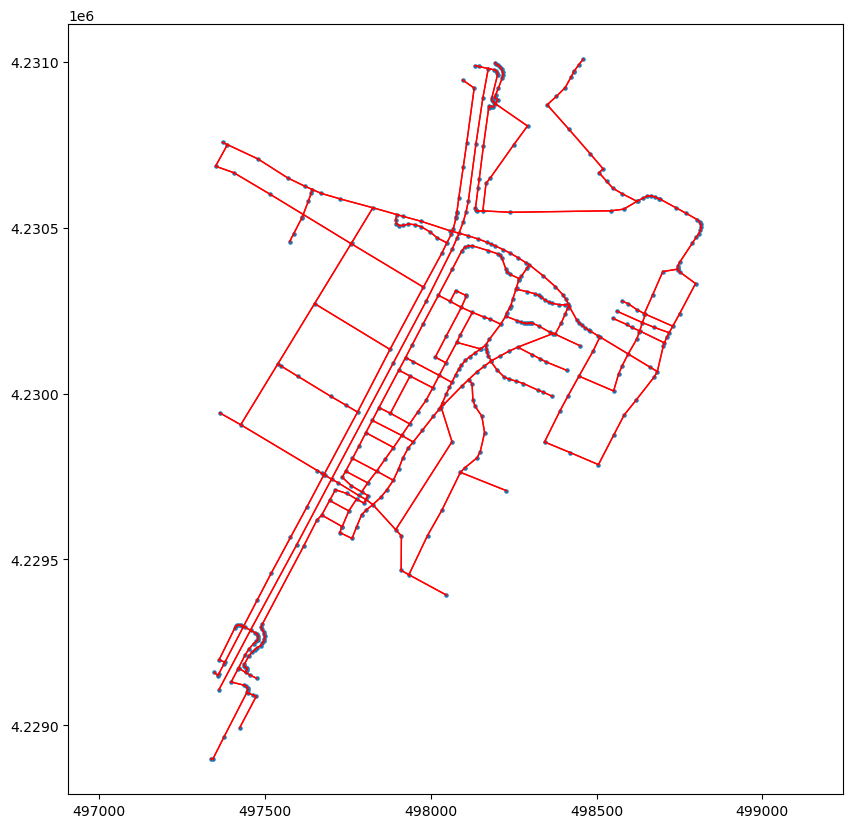

In [10]:
#create linksdb and nodesdb
createLinksAndNodes(G, shelters, plot=True)

In [11]:
# Create actionsdb and transitionsdb
actrans.setMatrices()

# Dissaggregate population
df = pd.read_csv("./data/nodesdb.csv")
nodes = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.coord_x, df.coord_y),crs=6691)
Gn = nodes
gdf_int_wgs84 = pop
Gn['pop']=[None]*Gn.shape[0]
Gn_p = Gn.to_crs(crs=6691)
gdf_int_wgs84.drop_duplicates(subset=['mesh','TotalPop'],inplace=True)
Census_p = gdf_int_wgs84.to_crs(crs=6691)
for i in range(gdf_int_wgs84.shape[0]-1):
    pip = gpd.sjoin(Gn, gdf_int_wgs84.iloc[i:i+1,:], how="inner", predicate='intersects')
    if pip.empty:
        pip = Census_p.iloc[i:i+1,:].sjoin_nearest(Gn_p, how="inner")
    n = pip.shape[0]
    t = float(pip['TotalPop'].values[0])
    a = np.round(t/n)
    for idx, piprow in pip.iterrows():
        if Gn.loc[idx,"pop"] is None:
            Gn.loc[idx,"pop"]=a
        else:
            Gn.loc[idx,"pop"]=Gn.loc[idx,"pop"]+a
#spread the difference among nodes with the smallest number of agents
diff = np.ceil(sum([float(x) for x in Census_p['TotalPop']]))-Gn['pop'].sum()
while diff > 5:
    num_nodes = Gn[Gn["pop"]==Gn["pop"].min()].shape[0]
    for idx, row in Gn[Gn["pop"]==Gn["pop"].min()].iterrows():
        Gn.loc[idx,'pop']=Gn.loc[idx,'pop']+np.round(diff/num_nodes)
    diff = np.ceil(sum([float(x) for x in Census_p['TotalPop']]))-Gn['pop'].sum()

# Create the agentsdb
num_people = Gn["pop"].sum().astype("int64")
agentsdb = pd.DataFrame()
agentsdb['age'] = [ 0 ] * num_people
agentsdb['gender'] = [ 0 ] * num_people
agentsdb['hhType'] = [ 0 ] * num_people
agentsdb['hhId'] = [ 0 ] * num_people
agentsdb['Node'] = [ -1 ] * num_people
prev_sum = 0
for i,r in Gn.iterrows():
    if r['pop'] != None:
        agg_pop = int(Gn['pop'].loc[:i].sum())
        for j in range(prev_sum,prev_sum+int(r['pop'])):
            agentsdb.iat[j,4] = int(r['# number'])
        prev_sum = agg_pop
    # else:
    #     agentsdb['Node'].iloc[i] = None
agentsdb = agentsdb.dropna()
agentsdb['Node']=agentsdb['Node'].astype('int64')
agentsdb.to_csv('./data/agentsdb.csv',index=False)

copyDataFolder(case)

In [ ]:
# FALTA ARREGLAR ACTIONS IN TRANSITIONS Y ADICIONAR SHELTERS

In [ ]:
import pandas as pd

n = pd.read_csv('../../arahama_0/data/nodesdb.csv')
l = pd.read_csv('../../arahama_0/data/linksdb.csv')
a = pd.read_csv('../../arahama_0/data/actionsdb.csv',header=None) 
t = pd.read_csv('../../arahama_0/data/transitionsdb.csv',header=None)

In [ ]:
# actions in evacuaiton nodes need to be 1 as -1
# 149 1 -1
# transitions at evacuation nodes need 1 to the same node (149)
# 149 1 149
a[a[0]==149]

In [ ]:
# l[l['node2']==6]
t[t[0]==149]

In [ ]:
n[n[' evacuation']==1]

In [ ]:
l[l['node2']==149]

In [ ]:
l[l['node1']==19]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')

length = []
for i in range(l.shape[0]):
    p1 = [n.iloc[l['node1'][i]][1],n.iloc[l['node2'][i]][1]]
    p2 = [n.iloc[l['node1'][i]][2],n.iloc[l['node2'][i]][2]]
    length.append(np.ceil(np.sqrt((p1[1]-p1[0])**2 + (p2[1]-p2[0])**2)))
    plt.plot(p1, p2)
    plt.axis('equal')

In [ ]:
l['len']=length

In [ ]:
l.head()

In [ ]:
import contextily as ctx

plt.style.use('default')

fig,ax = plt.subplots()
pop.plot(column='TotalPop',ax=ax,legend=True)
df = pd.read_csv("./data/nodesdb.csv")
nodes = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.coord_x, df.coord_y),crs=6691)
nodes.plot(ax=ax)

ctx.add_basemap(ax,zoom=18,
                crs=pop.crs.to_string(),
                source=ctx.providers.Esri.WorldImagery
                )
# gs = gpd.GeoSeries(nodes.geometry)
# ninarea = nodes[gs.within(poly)]

# for i in range(edDB.shape[0]):
#         indS, indT= int(edDB[i,1]), int(edDB[i,2])
#         # print("here",indS, indT)
#         plt.plot([ noDB[indS,1], noDB[indT,1] ],[ noDB[indS,2],noDB[indT,2] ], c="r", lw=1)

In [ ]:
Gn = nodes
gdf_int_wgs84 = pop
Gn['pop']=[None]*Gn.shape[0]
Gn_p = Gn.to_crs(crs=6691)
gdf_int_wgs84.drop_duplicates(subset=['mesh','TotalPop'],inplace=True)
Census_p = gdf_int_wgs84.to_crs(crs=6691)
for i in range(gdf_int_wgs84.shape[0]-1):
    pip = gpd.sjoin(Gn, gdf_int_wgs84.iloc[i:i+1,:], how="inner", predicate='intersects')
    if pip.empty:
        pip = Census_p.iloc[i:i+1,:].sjoin_nearest(Gn_p, how="inner")
    n = pip.shape[0]
    t = float(pip['TotalPop'].values[0])
    a = np.round(t/n)
    for idx, piprow in pip.iterrows():
        if Gn.loc[idx,"pop"] is None:
            Gn.loc[idx,"pop"]=a
        else:
            Gn.loc[idx,"pop"]=Gn.loc[idx,"pop"]+a
#spread the difference among nodes with the smallest number of agents
diff = np.ceil(sum([float(x) for x in Census_p['TotalPop']]))-Gn['pop'].sum()
while diff > 5:
    num_nodes = Gn[Gn["pop"]==Gn["pop"].min()].shape[0]
    for idx, row in Gn[Gn["pop"]==Gn["pop"].min()].iterrows():
        Gn.loc[idx,'pop']=Gn.loc[idx,'pop']+np.round(diff/num_nodes)
    diff = np.ceil(sum([float(x) for x in Census_p['TotalPop']]))-Gn['pop'].sum()

In [ ]:
import contextily as ctx

plt.style.use('default')

fig,ax = plt.subplots()
pop.plot(column='TotalPop',ax=ax,legend=True)
df = pd.read_csv("./data/nodesdb.csv")
nodes = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.coord_x, df.coord_y),crs=6691)
Gn.plot(column='pop', ax=ax, legend=True,cmap='jet',legend_kwds={'ncol':3})
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.6, 0.8, 0.4, 0.2))
ctx.add_basemap(ax,zoom=18,
                crs=pop.crs.to_string(),
                source=ctx.providers.Esri.WorldImagery
                )
# gs = gpd.GeoSeries(nodes.geometry)
# ninarea = nodes[gs.within(poly)]

# for i in range(edDB.shape[0]):
#         indS, indT= int(edDB[i,1]), int(edDB[i,2])
#         # print("here",indS, indT)
#         plt.plot([ noDB[indS,1], noDB[indT,1] ],[ noDB[indS,2],noDB[indT,2] ], c="r", lw=1)

In [ ]:
num_people = Gn["pop"].sum().astype("int64")
agentsdb = pd.DataFrame()
agentsdb['age'] = [ 0 ] * num_people
agentsdb['gender'] = [ 0 ] * num_people
agentsdb['hhType'] = [ 0 ] * num_people
agentsdb['hhId'] = [ 0 ] * num_people
agentsdb['Node'] = [ -1 ] * num_people
prev_sum = 0
for i,r in Gn.iterrows():
    if r['pop'] != None:
        agg_pop = int(Gn['pop'].loc[:i].sum())
        for j in range(prev_sum,prev_sum+int(r['pop'])):
            agentsdb.iat[j,4] = int(r['# number'])
        prev_sum = agg_pop
    # else:
    #     agentsdb['Node'].iloc[i] = None
agentsdb = agentsdb.dropna()
agentsdb['Node']=agentsdb['Node'].astype('int64')
agentsdb.to_csv('./data/agentsdb.csv',index=False)